### 作业2  SA19225404 吴语港

写代码生成一个包含200条数据的数据集（数据集的具体要求见步骤1） ），
再按照步骤2）~步骤4）的要求生成指定模型，训练模型、
并分别画出训练过程中模型在训练集和验证集上的学习曲线，
利用学习曲线判断模型是欠拟合状态、过拟合状态，还是表现正好。

In [35]:
#准备工作
import d2lzh as d2l
#numpy
import numpy as np
#数据预处理
from sklearn import preprocessing 
#需要先pip好mxnet，再导入gluon，nd
from mxnet import autograd, gluon, nd
#导入数据，起小名
from mxnet.gluon import data as gdata, loss as gloss, nn

1）⽣成⼀个⼈⼯数据集。在训练数据集和测试数据集中，给定样本特征x，我们使⽤如下的三阶多项式函数来⽣成该样本的标签：
                        $y=1.2x−3.4x2+5.6x3+5+ϵ$
其中噪声项ϵ服从均值为0、标准差为0.1的正态分布。训练数据集和测试数据集的样本数都设为100。

In [49]:
#训练集大小，测试集大小，多项式的系数（权重数组），常数项偏置
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
#【200x1矩阵】一维随机数正态分布，参数初始化，做输入x也就是features，一阶拟合
features = nd.random.normal(shape=(n_train + n_test, 1))
#【200x3矩阵】一次项，二次项，三次项，不带系数（权重），可以看成中间变量，三阶拟合
poly_features = nd.concat(features, nd.power(features, 2),nd.power(features, 3))
#【200x10矩阵】十阶拟合使用，容易nan，需要标准化或者调低学习率
ten_features = nd.concat(features, nd.power(features, 2),nd.power(features, 3), 
                         nd.power(features, 4),nd.power(features, 5), 
                         nd.power(features, 6),nd.power(features, 7),
                         nd.power(features, 8),nd.power(features, 9),nd.power(features,10))
#标准化
# a = nd.array(ten_features, dtype=np.float64)
# a = np.concatenate(a, axis=0)
# preprocessing.scale(a)
#【1x200矩阵】三阶多项式函数生成数据，带上系数计算，并加上常数偏置，进行求和
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
#【1x200】加上方差为0.1的正态分布噪声
labels += nd.random.normal(scale=0.1, shape=labels.shape)

In [37]:
#查看样本全体，输入与输出
features[:], poly_features[:],ten_features[:], labels[:]

(
 [[ 0.12576538]
  [-0.22553162]
  [-0.08724168]
  [-1.9982861 ]
  [ 0.2652651 ]
  [-0.53809524]
  [ 0.7415213 ]
  [-1.1023985 ]
  [ 0.4312621 ]
  [ 0.04796332]
  [ 1.0383999 ]
  [-0.6669437 ]
  [ 0.536152  ]
  [ 0.85688543]
  [-1.1319188 ]
  [-0.70708483]
  [ 0.83172685]
  [-0.3453634 ]
  [ 1.4978392 ]
  [ 0.642728  ]
  [-0.01772865]
  [-2.7624755 ]
  [ 0.70027727]
  [-0.40241793]
  [-0.09507764]
  [-1.0602223 ]
  [-0.0284882 ]
  [ 1.4242371 ]
  [ 2.8982308 ]
  [-1.2253977 ]
  [-0.84328055]
  [ 0.88106   ]
  [ 0.1136774 ]
  [-1.609424  ]
  [-0.41303247]
  [ 2.2879524 ]
  [-0.88596725]
  [-0.83625084]
  [ 0.8604862 ]
  [ 0.9609362 ]
  [-0.685047  ]
  [-0.25356722]
  [ 0.8301784 ]
  [ 0.8131436 ]
  [-0.24233957]
  [ 0.800346  ]
  [ 0.47322297]
  [-0.05364884]
  [-1.5491834 ]
  [ 0.09825653]
  [ 0.29727766]
  [-0.8730638 ]
  [ 2.0189908 ]
  [-0.728708  ]
  [-0.6191371 ]
  [-0.06395611]
  [-2.3897045 ]
  [-0.3885556 ]
  [ 2.0347214 ]
  [-0.25581995]
  [ 0.3952196 ]
  [ 1.1336962 ]
  [-0.

In [38]:
#定义作图函数，y轴为对数尺度
#x1值，y1值，x标注，y标注，x2值，y2值，图例，窗口大小
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)#设置窗口大小默认3.5*2.5
    d2l.plt.xlabel(x_label)#显示x轴意义
    d2l.plt.ylabel(y_label)#显示y轴意义
    d2l.plt.semilogy(x_vals, y_vals)#进行第一条曲线的绘制
    if x2_vals and y2_vals:#如果有第二条曲线，就要画第二条线，并显示图例
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')#进行第二条曲线的绘制
        d2l.plt.legend(legend)#显示图例

In [61]:
#定义训练+显示一体化函数
#批次数，误差，
num_epochs, loss = 100, gloss.L2Loss()
#参数列表：训练输入，测试输入，训练输出，测试输出，学习率
def fit_and_plot(train_features, test_features, train_labels, test_labels,learnrate ):
    net = nn.Sequential()#一个有序的容器
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])#批大小超过10个按10个记
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    #训练器采用随机梯度下降SGD训练，学习率为learnrate做输入参数
    trainer = gluon.Trainer(net.collect_params(), 'sgd',{'learning_rate': learnrate})
    train_ls, test_ls = [], []#定义损失初值
    for _ in range(num_epochs):#不同训练批次
        for X, y in train_iter:#监督学习不同的特征与标签
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        #训练，每一批后的损失值，并外挂到train_ls
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        #测试，每一批后的损失值，并外挂到test_ls
        test_ls.append(loss(net(test_features),
                            test_labels).mean().asscalar())
    #最后的训练与测试误差
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    #不同批次训练的结果，不同批次测试的结果，显示窗口
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net[0].weight.data().asnumpy(),#输出训练后得出的系数（权重）
          '\nbias:', net[0].bias.data().asnumpy())#输出训练后得出的常数项（偏置）

2）先使⽤与数据⽣成函数同阶的三阶多项式函数拟合。

①打印出最佳参数的取值，与真实参数值进行对比，并对结果进行分析点评；

②尝试画出训练过程中模型分别在训练集和验证集上的学习曲线；观察分析这2条学习曲线，判断该模型是欠拟合，还是过拟合，还是表现很好？请说明理由。

③尝试使用不同的学习率η（四种情况：过大，过小，正好），画出不同的学习率η下，模型在训练集上的学习曲线；对比观察这三条学习曲线的走势，分析学习率对训练过程的影响。

final epoch: train loss 0.003913792 test loss 0.0059956
weight: [[ 1.2012036 -3.4033813  5.6022115]] 
bias: [5.0179133]


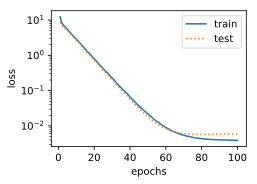

In [40]:
#三阶拟合（模型复杂度刚刚好，学习率也刚刚好，最合适）学习率0.01
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
             labels[:n_train], labels[n_train:], 0.01)

final epoch: train loss 4.5542353e+34 test loss 1.6489693e+34
weight: [[-7.1200714e+16  6.7360635e+16 -4.5346428e+16]] 
bias: [5.350943e+16]


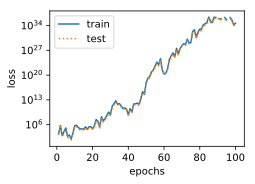

In [43]:
#三阶拟合（模型复杂度刚刚好，学习率过大导致发散）学习率0.1
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
             labels[:n_train], labels[n_train:], 0.1)

final epoch: train loss 0.0044334345 test loss 0.006539675
weight: [[ 1.2146236 -3.4069202  5.606834 ]] 
bias: [5.0215087]


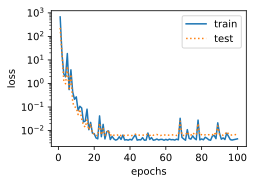

In [44]:
#三阶拟合（模型复杂度刚刚好，学习率稍大学习曲线有点震荡）学习率0.05
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
             labels[:n_train], labels[n_train:], 0.05)

final epoch: train loss 2.9103785 test loss 2.8517141
weight: [[ 0.9256708 -2.3574617  5.750919 ]] 
bias: [1.9527975]


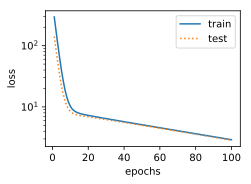

In [12]:
#三阶拟合（模型复杂度刚刚好，不过过小的学习率导致学习太慢了）学习率0.001
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
             labels[:n_train], labels[n_train:], 0.001)

3）再试试线性函数拟合。

尝试画出训练过程中模型分别在训练集和验证集上的学习曲线；观察分析这2条学习曲线，判断该模型是欠拟合，还是过拟合，还是表现很好？请说明理由，并指出改进方案。

final epoch: train loss 50.17723 test loss 93.4331
weight: [[14.462653]] 
bias: [2.2241619]


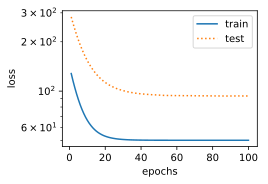

In [50]:
#线性拟合（模型太简单，会导致欠拟合）训练和测试的loss都很差
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:],0.01)

4）使⽤三阶多项式函数模型来拟合，请注意，这次，只使⽤2个样本来训练模型。

①打印出最佳参数的取值，并与真实参数值进行对比，并对结果进行分析点评。

②尝试画出训练过程中模型分别在训练集和验证集上的学习曲线；观察分析这2条学习曲线，判断该模型是欠拟合，还是过拟合，还是表现很好？请说明理由，并指出改进方案。

final epoch: train loss 0.004758147 test loss 19.740759
weight: [[ 2.4169416  -0.21812136  4.527212  ]] 
bias: [-0.44129366]


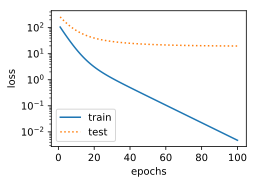

In [51]:
#三阶拟合，训练样本不足（欠拟合）需要更多的训练数据，后面的曲线应该是延伸的
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:],0.01)

5）使⽤10阶多项式函数模型来拟合。

①打印出最佳参数的取值，并与真实参数值进行对比；

②尝试画出训练过程中模型分别在训练集和验证集上的学习曲线；观察分析这2条学习曲线，判断该模型是欠拟合，还是过拟合，还是表现很好？请说明理由，并指出改进方案。

③尝试利用L2正则化技术，让该模型的表现好起来。画出训练过程中模型分别在训练集和验证集上的学习曲线；观察分析这2条学习曲线，判断该模型是欠拟合，还是过拟合，还是表现很好？并说明理由。

④打印出③中模型的最佳参数，并与①进行对比，尝试总结下L2正则化技术所带来的效果，并分析为何L2正则化技术可以解决过拟合问题。

⑤ 在③中使用不同的正则化强度，打印出不同正则化强度下的最佳参数，并对结果进行分析点评。

final epoch: train loss 41.39038 test loss 367.50558
weight: [[-0.06136507  0.00243929 -0.0610089  -0.00351013  0.05785299 -0.04326928
   0.0338949  -0.00164474  0.04598321  0.00667603]] 
bias: [6.871514e-05]


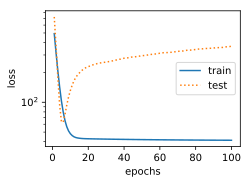

In [62]:
#十阶拟合（模型太复杂，会导致过拟合）
fit_and_plot(ten_features[:n_train, :],ten_features[n_train:, :], labels[:n_train],
             labels[n_train:],0.00000004)

### 可以看出来最佳参数的取值，与真实参数值出入较大,而且有过拟和的现象，一般解决这种问题的方法如下
## 1.正则化方法，也就是权重衰减
## 2.加大训练数据
## 3.去掉神经网络的一部分进行训练，也就是丢弃法
## 4.提前终止

In [56]:
#进行L2正则化，定义惩罚项
def l2_penalty(w):
    return (w**2).sum() / 2

In [57]:
#加入了L2正则化的拟合函数
#批次数，误差，
num_epochs, loss = 100, gloss.L2Loss()
#参数列表：训练输入，测试输入，训练输出，测试输出，学习率,惩罚项系数
def fit_and_plot_L2(train_features, test_features, train_labels, test_labels,learnrate ,lambd):
    net = nn.Sequential()#一个有序的容器
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])#批大小超过10个按10个记
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    #训练器采用随机梯度下降SGD训练，学习率为learnrate做输入参数
    trainer = gluon.Trainer(net.collect_params(), 'sgd',{'learning_rate': learnrate})
    train_ls, test_ls = [], []#定义损失初值
    for _ in range(num_epochs):#不同训练批次
        for X, y in train_iter:#监督学习不同的特征与标签
            with autograd.record():
                # 添加了L2范数惩罚项
                l = loss(net(X), y) + lambd * l2_penalty(net[0].weight.data().asnumpy())
            l.backward()
            trainer.step(batch_size)
        #训练，每一批后的损失值，并外挂到train_ls
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        #测试，每一批后的损失值，并外挂到test_ls
        test_ls.append(loss(net(test_features),
                            test_labels).mean().asscalar())
    #最后的训练与测试误差
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    #不同批次训练的结果，不同批次测试的结果，显示窗口
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net[0].weight.data().asnumpy(),#输出训练后得出的系数（权重）
          '\nbias:', net[0].bias.data().asnumpy())#输出训练后得出的常数项（偏置）

final epoch: train loss 45.867153 test loss 205.78508
weight: [[ 0.05440721  0.01373051 -0.00670504 -0.03651985  0.05950128  0.01235772
  -0.03963249 -0.04367105  0.04960401  0.0093249 ]] 
bias: [8.3577805e-05]


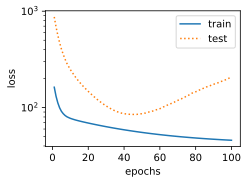

In [58]:
#十阶拟合（模型太复杂）加入了L2惩罚项，lambd=1，还是有过拟和
fit_and_plot_L2(ten_features[:n_train, :],ten_features[n_train:, :], labels[:n_train],
             labels[n_train:],0.00000004,1)

final epoch: train loss 68.418335 test loss 196.00613
weight: [[-0.00789979  0.0175912  -0.05790495 -0.01933222  0.03253733  0.05781509
  -0.01514692  0.05282685  0.02166412 -0.01926502]] 
bias: [8.2431376e-05]


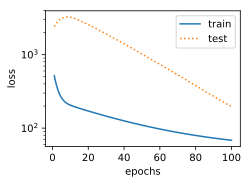

In [59]:
#十阶拟合（模型太复杂）加入了L2惩罚项，lambd=0.1，过拟和消失了
fit_and_plot_L2(ten_features[:n_train, :],ten_features[n_train:, :], labels[:n_train],
             labels[n_train:],0.00000004,0.1)

final epoch: train loss 42.74672 test loss 137.46866
weight: [[ 0.02450505  0.03014343  0.0049615   0.00328209 -0.02436037 -0.02484084
   0.0810871  -0.06879107  0.02687113  0.01341972]] 
bias: [8.616818e-05]


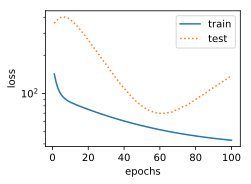

In [63]:
#十阶拟合（模型太复杂）加入了L2惩罚项，lambd=10，还是有过拟和，看来lambd不能太大
fit_and_plot_L2(ten_features[:n_train, :],ten_features[n_train:, :], labels[:n_train],
             labels[n_train:],0.00000004,10)

final epoch: train loss 58.013126 test loss 96.21356
weight: [[-0.00370966  0.02089359 -0.01593382 -0.06911948  0.07090588  0.06669808
  -0.03134783  0.02703604  0.03238817 -0.01092693]] 
bias: [8.282152e-05]


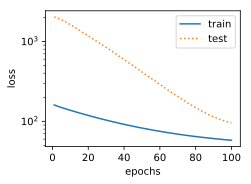

In [64]:
#十阶拟合（模型太复杂）加入了L2惩罚项，lambd=0.01，调小了lambd更好一些了,目前是最好的情况
fit_and_plot_L2(ten_features[:n_train, :],ten_features[n_train:, :], labels[:n_train],
             labels[n_train:],0.00000004,0.01)

L1和L2正则都是比较常见和常用的正则化项，都可以达到防止过拟合的效果。L1正则化的解具有稀疏性，可用于特征选择。L2正则化的解都比较小，抗扰动能力强。在求解过程中，L2通常倾向让权值尽可能小，最后构造一个所有参数都比较小的模型。因为一般认为参数值小的模型比较简单，能适应不同的数据集，也在一定程度上避免了过拟合现象。参数足够小，数据偏移得多一点也不会对结果造成什么影响，可以说“抗扰动能力强”。

过拟合的时候，拟合函数的系数往往非常大，就是拟合函数需要顾忌每一个点，最终形成的拟合函数波动很大。在某些很小的区间里，函数值的变化很剧烈。这就意味着函数在某些小区间里的导数值（绝对值）非常大，由于自变量值可大可小，所以只有系数足够大，才能保证导数值很大。

而正则化是通过约束参数的范数使其不要太大，所以可以在一定程度上减少过拟合情况。

final epoch: train loss 48.949074 test loss 263.03705
weight: [[ 0.0661952   0.01285097 -0.05049563 -0.0209086  -0.05381117  0.01980051
  -0.01213619  0.01173303  0.05252288  0.00036133]] 
bias: [4.4678276e-05]


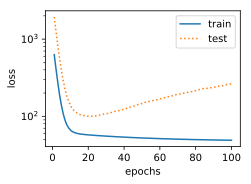

In [67]:
#十阶拟合（模型太复杂）加入了L2惩罚项，lambd=0.0001，继续调小了，又出现了过拟和，看来lambd在0.01的数量级比较合适
fit_and_plot_L2(ten_features[:n_train, :],ten_features[n_train:, :], labels[:n_train],
             labels[n_train:],0.00000004,0.0001)

### 总的来说还是要模型好最重要，用10阶去拟合的话，正则化的效果都不如用三阶去拟合